In [101]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## ดึงข้อมูล Stock, ETF จาก yfinance

In [102]:
#รายชื่อหุ้น, ETF
tickerList = [
    "AAPL",  # Technology (Apple)
    "XOM",  # Energy (ExxonMobil)
    "JNJ",  # Healthcare (Johnson & Johnson)
    "GOOGL",  # Technology (Alphabet/Google)
    "TLT",  # ETF (Long-term Treasuries)
    "GLD",  # Commodity (Gold)
    "VNQ",  # ETF (Real Estate)
    "EFA",  # ETF (Developed Markets)
    "BND",  # ETF (Total Bond Market)
    "ARKK",  # ETF (Innovation/Tech-focused)
]


#ดึงข้อมูลทุก ๆ 1 วัน ย้อนหลัง 5 ปี
series = {}
for name in tickerList :
    data = yf.Ticker(name)
    series[name] = data.history(interval="1d", period="5y")['Close'].pct_change().dropna()

df = pd.DataFrame(series)

# Markowitz Model Portfolio

เป็นวิธีแรกเริ่มของ Portfolio Optimization และ Modern Portfolio Theory (MPT) คิดค้นโดย Harry Markowitz ผู้เป็นเจ้าของรางวัลโนเบล MPT แต่ใช้งานจริงได้ไม่ดี เนื่องจาก Correlation ขึ้นกับ Timeframe และตัวแปรบางตัวมีความ sensitive มาก

## 1) เลือก Stock ที่มี Correlation ต่ำ

<Axes: >

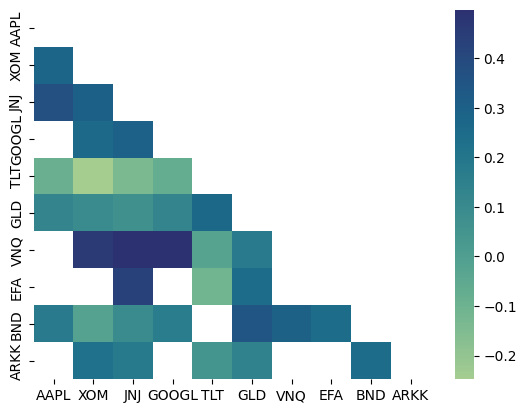

In [61]:
corr = df.corr()
triMask = np.triu(np.ones_like(corr, dtype=bool))
filterMask = corr>0.5
mixMask = triMask|filterMask
sns.heatmap(corr,cmap='crest', mask=mixMask)

In [105]:
chosen = df[['BND','EFA','GOOGL','JNJ','GLD']]

## 2) Monte Carlo Simulation

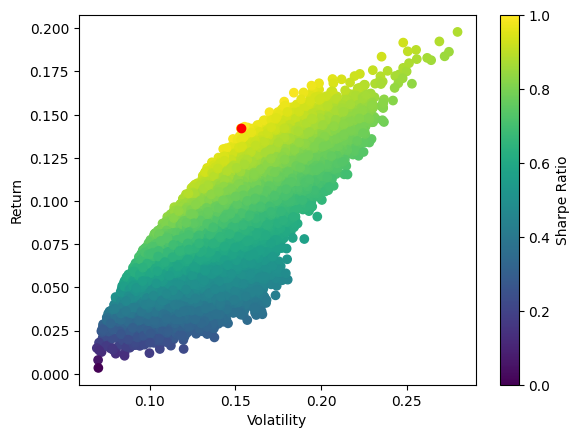

In [108]:
avgRet = np.array((chosen+1).prod()**(1/5)-1)
cov_matrix = chosen.cov() * 252

n = chosen.shape[1]
sample = 50000

results = np.zeros((sample,3))
maxSharpe = 0

for i in range(sample):
    weights = np.random.rand(n,1)
    weights /= np.sum(weights)
    
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    ret = avgRet @ weights
    sharpe = (ret - 0.03) / vol

    if sharpe > maxSharpe :
        maxSharpe = sharpe
        maxWeights = weights
        maxVol = vol
        maxRet = ret
    
    results[i, 0] = np.squeeze(ret)
    results[i, 1] = np.squeeze(vol)
    results[i, 2] = np.squeeze(sharpe)

    if i%1000 == 0 : #debug
        #print(avgRet,weights,ret)
        pass

plt.scatter(results[:, 1], results[:, 0], c=results[:, 2], cmap='viridis')
plt.scatter(maxVol, maxRet, c='red')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Ratio')
plt.show()

##  In Development : Black Litterman's portfolio, Risk Parity